## Hello 🖐🏼
In this project, we followed these steps to build an image classification model:

#Data preparation:

* Downloaded and extracted the food image dataset.
* Explored the directory structure and counted images in each class.
* Split the dataset into training and validation sets.

#Data augmentation:

* Created a data augmentation layer to introduce random variations in images (e.g., rotation, resizing, flipping) to increase data diversity.

#Transfer learning:

* Utilized the pre-trained EfficientNetV2B0 model trained on the ImageNet dataset.
* Froze the layers of the base model to prevent their weights from being updated in the initial training stages.
* Added a new classification head to the base model to adapt it to the food dataset.

#Model training:

* Compiled the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.
* Trained the model using the training dataset and validated it with the validation dataset.
* Used TensorBoard to monitor the model's performance during training.

#Fine-tuning:

* Unfroze some of the last layers of the base model to fine-tune their weights specifically for the food dataset.
* Reduced the learning rate to prevent drastic weight changes and improve model performance.

#Evaluation:

* Compared the model's performance before and after fine-tuning using loss and accuracy plots.
* Visualized the model's predictions on random images from the validation dataset.


Overall, this project demonstrated how to leverage pre-trained models and fine-tuning techniques to achieve good performance on a new image classification task, even with limited data.😊👍

In [1]:
# Import necessary libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import os, datetime
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
import zipfile
import random
import matplotlib.image as mpimg

In [2]:
# Download and extract the dataset if it doesn't exist

if not os.path.exists('10_food_classes_10_percent.zip'):
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-09-14 09:06:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   130MB/s    in 1.2s    

2024-09-14 09:06:10 (130 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Explore the directory structure and count files

for root,folder,files in os.walk('10_food_classes_10_percent'):
  print(f"There is {len(folder)} folder and {len(files)} images in {root}")

There is 2 folder and 0 images in 10_food_classes_10_percent
There is 10 folder and 0 images in 10_food_classes_10_percent/test
There is 0 folder and 250 images in 10_food_classes_10_percent/test/pizza
There is 0 folder and 250 images in 10_food_classes_10_percent/test/fried_rice
There is 0 folder and 250 images in 10_food_classes_10_percent/test/ramen
There is 0 folder and 250 images in 10_food_classes_10_percent/test/ice_cream
There is 0 folder and 250 images in 10_food_classes_10_percent/test/chicken_curry
There is 0 folder and 250 images in 10_food_classes_10_percent/test/steak
There is 0 folder and 250 images in 10_food_classes_10_percent/test/hamburger
There is 0 folder and 250 images in 10_food_classes_10_percent/test/sushi
There is 0 folder and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There is 0 folder and 250 images in 10_food_classes_10_percent/test/chicken_wings
There is 10 folder and 0 images in 10_food_classes_10_percent/train
There is 0 folder and 75 i

In [4]:
# Set the paths to the training and validation directories

train_dir = '/content/10_food_classes_10_percent/train'
validation_dir = '/content/10_food_classes_10_percent/test'

In [5]:
# Define the image size
IMG_SIZE = (224,224)


# Load the training and validation datasets using image_dataset_from_directory
print("Train Data : ")
train_data = image_dataset_from_directory(train_dir,
                                          label_mode='categorical',
                                          image_size = IMG_SIZE,

                                          )

print("Validation Data : ")
validation_data = image_dataset_from_directory(validation_dir,
                                               label_mode= 'categorical',
                                               image_size = IMG_SIZE)

Train Data : 
Found 750 files belonging to 10 classes.
Validation Data : 
Found 2500 files belonging to 10 classes.


In [7]:
# Define a function to display a random image from a specified class

def random_image(diractory, class_name,show_img=True):

  path = diractory + '/' + class_name

  img_name = random.choice(
          os.listdir(path)
      )

  img = mpimg.imread(path + '/' + img_name)



  if show_img :
    plt.imshow(img/255.)
    plt.title(class_name)
    plt.axis(False)

  return img


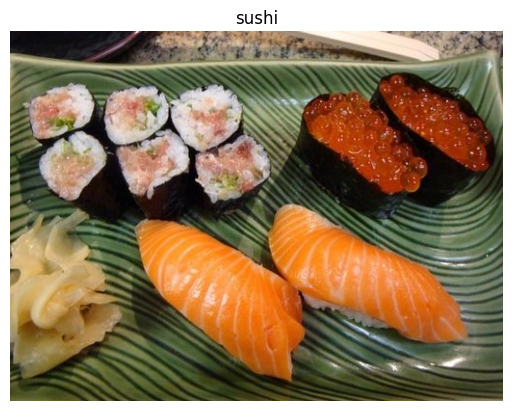

In [8]:
# Display a random image from the sushi class in the validation directory

img = random_image(validation_dir, 'sushi')

In [10]:
# Define a function to create a TensorBoard callback

def create_tensornoard(logdir , expriment):
  logdir = os.path.join(logdir, expriment + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [11]:
# Define data augmentation layers

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip('horizontal')
])

In [29]:
# Set random seed for reproducibility
tf.random.set_seed (42)

# Load a pre-trained EfficientNetV2B0 model without the top layers
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Freeze the layers in the base model
for layer in base_model.layers:
  layer.trainable=False

# Define the input layer
inputs =  tf.keras.layers.Input(shape = IMG_SIZE + (3,), name='Input_Layer')


# Apply data augmentation to the inputs
x = data_augmentation(inputs)

# Pass the augmented inputs to the base model
x = base_model(x)

# Apply global average pooling to the output of the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Define the output layer with 10 class and softmax activation
outputs = tf.keras.layers.Dense(10,
                                activation=tf.keras.activations.softmax,
                                name="Output_layer")(x)


# Create the model
model_1 = tf.keras.Model(inputs,outputs)


# Define the checkpoint path and create a ModelCheckpoint callback
checkpoint_path = 'checkpoints.weights.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only = True,
                                                verbose = 1)


# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss =tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])



# Set the number of initial epochs
initial_epochs = 5


# Train the model for the initial epochs
history_1 = model_1.fit(train_data,
                        epochs = initial_epochs,
                        validation_data = validation_data,
                        callbacks = [
                            create_tensornoard('models_log','history_1'),
                            checkpoint
                        ])

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.2208 - loss: 2.2021
Epoch 1: saving model to checkpoints.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 796ms/step - accuracy: 0.2247 - loss: 2.1949 - val_accuracy: 0.6692 - val_loss: 1.4706
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6448 - loss: 1.4636
Epoch 2: saving model to checkpoints.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 700ms/step - accuracy: 0.6465 - loss: 1.4595 - val_accuracy: 0.7648 - val_loss: 1.0296
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7371 - loss: 1.1219
Epoch 3: saving model to checkpoints.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 865ms/step - accuracy: 0.7375 - loss: 1.1195 - val_accuracy: 0.8036 - val_loss: 0.8238
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7916 - loss: 0.8721
Epoch 4: saving model to checkpoints.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 704ms/step - accuracy: 0.7919 - loss: 0.8718 - val_accuracy: 0.8284 - val_loss: 0.6

In [35]:
# Define a function to plot the loss and accuracy curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(loss, label = 'Training Loss')
  plt.plot(val_loss, label = 'Validation Loss')
  plt.title('Loss')
  plt.legend(loc = 'upper right')

  plt.subplot(1,2,2)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend(loc='lower right')

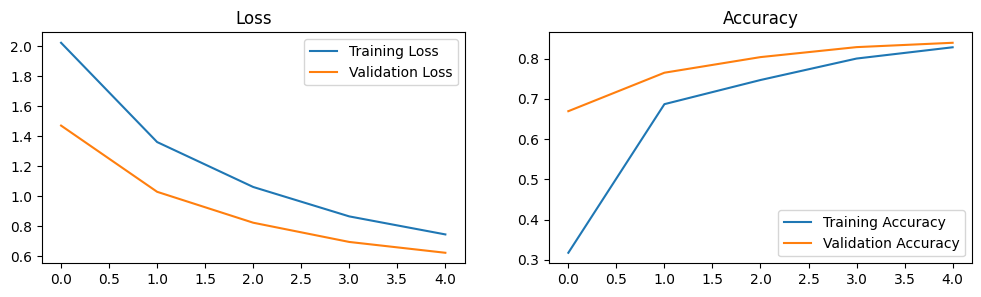

In [36]:
# Plot the loss and accuracy curves for the initial training
plot_loss_curves(history_1)

In [37]:
# Define a function to predict and display random images
def predict_some_random_image(model, test_dir, class_names):
  hight = 2
  width = 2
  plt.figure(figsize=(8,8))

  for i in range((hight*width)):
    plt.subplot(2,2,i+1)

    class_name = random.choice(class_names)
    img = tf.expand_dims(random_image(validation_dir,class_name,False),axis=0)
    img = tf.keras.layers.Resizing(224,224)(img)
    prob = model_1.predict(img)
    pred = tf.argmax(prob.reshape((10,)))
    plt.imshow(img[0]/255)
    plt.axis(False)
    plt.title(f"{tf.reduce_max(prob[0])*100:.2f}% is {class_names[pred]} ({class_name})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


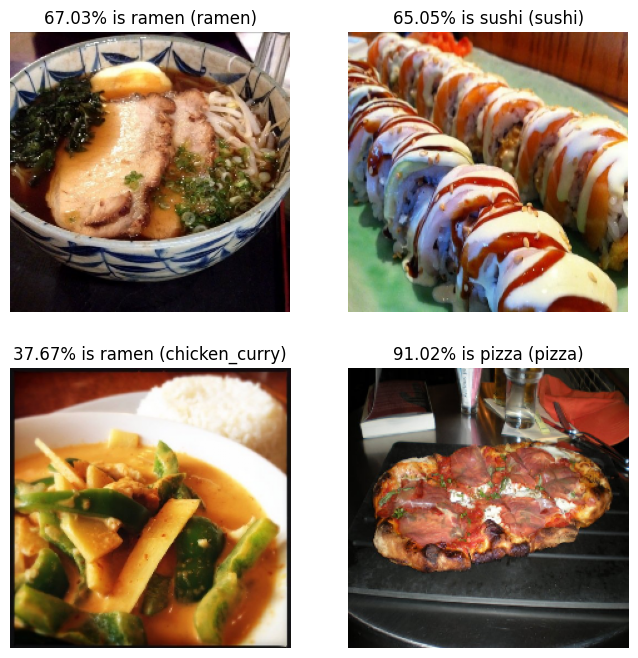

In [38]:
predict_some_random_image(model_1,validation_dir,validation_data.class_names)

In [45]:
# Unfreeze the last 10 layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
  layer.trainable = True

# Recompile the model with a lower learning rate
model_1.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

# Continue training the model with fine-tuning
history_2 = model_1.fit(train_data,
                        epochs = initial_epochs + 5,
                        validation_data = validation_data,
                        initial_epoch = history_1.epoch[-1],
                        callbacks = [
                            create_tensornoard(logdir='models_log',expriment='last_10_layer_fine_tune')
                        ]
                        )

Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - accuracy: 0.8148 - loss: 0.8769 - val_accuracy: 0.8456 - val_loss: 0.6530
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accuracy: 0.8262 - loss: 0.7708 - val_accuracy: 0.8472 - val_loss: 0.5927
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 599ms/step - accuracy: 0.8553 - loss: 0.6937 - val_accuracy: 0.8512 - val_loss: 0.5456
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 848ms/step - accuracy: 0.8520 - loss: 0.6797 - val_accuracy: 0.8540 - val_loss: 0.5269
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 637ms/step - accuracy: 0.8542 - loss: 0.6110 - val_accuracy: 0.8588 - val_loss: 0.4974
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 642ms/step - accuracy: 0.8664 - loss: 0.5593 - val_accuracy: 0.8628 - val_loss: 0.4722


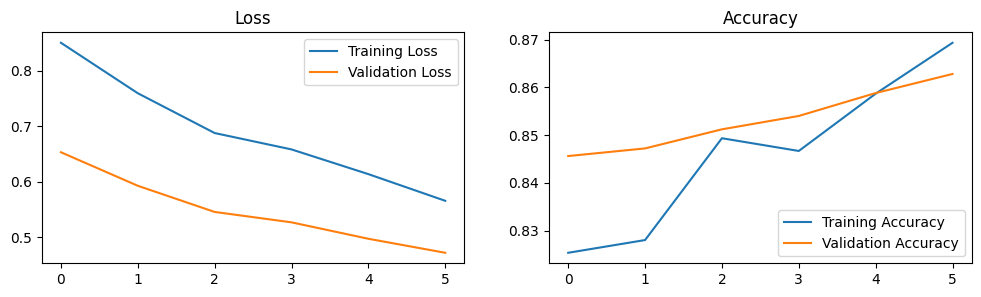

In [47]:
plot_loss_curves(history_2)

In [46]:
# Define a function to compare the training history before and after fine-tuning
def compare_history(original_history ,new_history, initial_epochs=5):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc= original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']


  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']


  plt.figure(figsize=(8,8))

  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label="Validation Accuracy")

  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label = "Strat Fine Tuning")
  plt.legend(loc = 'lower right')

  plt.title("Training And Validation Accuracy")



  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label="Validation Loss")

  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label = "Strat Fine Tuning")
  plt.legend(loc = 'upper right')

  plt.title("Training And Validation Loss")

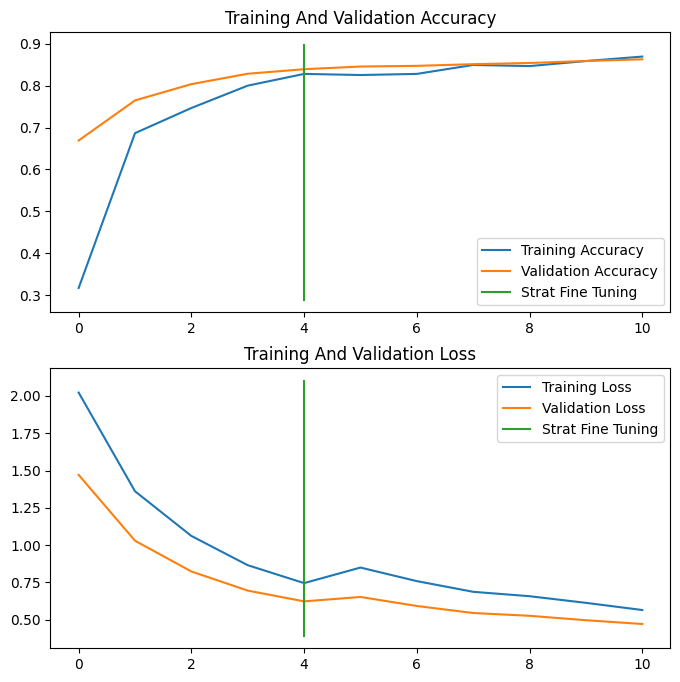

In [48]:
# Compare the training history before and after fine-tuning
compare_history(history_1,history_2,initial_epochs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


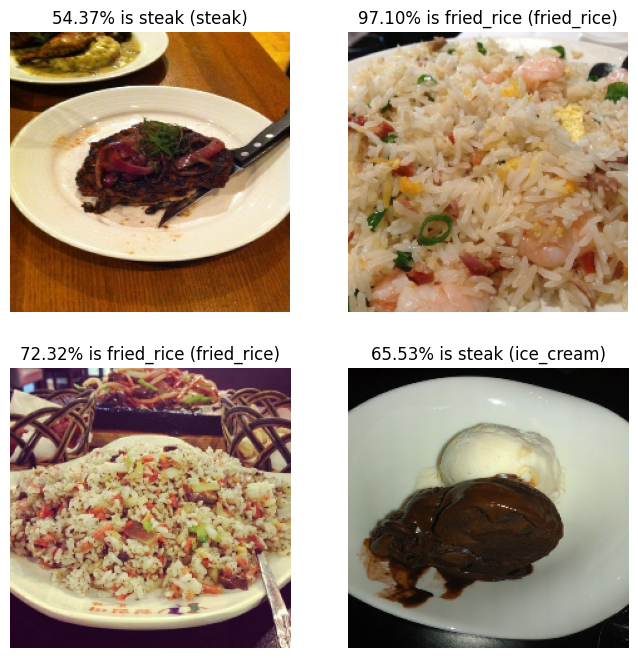

In [50]:
# Predict and display some random images after fine-tuning for last 10 layer
predict_some_random_image(model_1,validation_dir,validation_data.class_names)

In [51]:
# Unfreeze the last 20 layers of the base model for further fine-tuning
for layer in base_model.layers[-20:]:
  layer.trainable = True

# Recompile the model with a lower learning rate
model_1.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

# Continue training the model with further fine-tuning
history_2 = model_1.fit(train_data,
                        epochs = initial_epochs + 10,
                        validation_data = validation_data,
                        initial_epoch = history_2.epoch[-1],
                        callbacks = [
                            create_tensornoard(logdir='models_log',expriment='last_20_layer_fine_tune')
                        ]
                        )


Epoch 10/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 744ms/step - accuracy: 0.8773 - loss: 0.5574 - val_accuracy: 0.8640 - val_loss: 0.4857
Epoch 11/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 654ms/step - accuracy: 0.8824 - loss: 0.5449 - val_accuracy: 0.8672 - val_loss: 0.4852
Epoch 12/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 575ms/step - accuracy: 0.9146 - loss: 0.4491 - val_accuracy: 0.8704 - val_loss: 0.4526
Epoch 13/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 626ms/step - accuracy: 0.8694 - loss: 0.4885 - val_accuracy: 0.8732 - val_loss: 0.4384
Epoch 14/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 638ms/step - accuracy: 0.8984 - loss: 0.4439 - val_accuracy: 0.8764 - val_loss: 0.4315
Epoch 15/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.9154 - loss: 0.3792 - val_accuracy: 0.8784 - val_loss: 0.4222


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


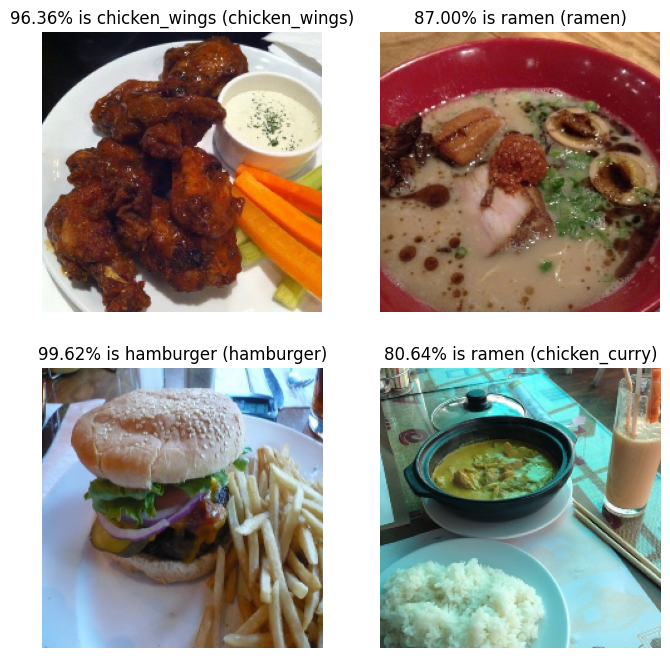

In [52]:
# Predict and display some random images after further fine-tuning
predict_some_random_image(model_1,validation_dir,validation_data.class_names)